In [1]:
from spectral_cube import SpectralCube #To read FITS
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from skimage import measure
from astropy import wcs
import cube_x3d as c3
import matplotlib.pyplot as plt
from matplotlib import cm
from astroquery.skyview import SkyView

In [65]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [2]:
%cd C:\Users\ixaka\Documents\Visualization

C:\Users\ixaka\Documents\Visualization


In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

In [4]:
def transpose(array, delta):
    dra, ddec, dv = delta
    return np.transpose(array, (2,1,0))[::int(np.sign(dra)), ::int(np.sign(ddec)),::int(np.sign(dv))]

In [11]:
# Read the fits file and save header
HI_cube = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_MRB_final_rss.fits')
cubehead = HI_cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = HI_cube.shape
print(HI_cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv))

(4300, 52, 58)


In [12]:
#half width of wanted wavelength axis
hw = 125

In [13]:
#borja MRB
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [0, nx-1]
limy = [0, ny-1]
#limz = [3450, 4100-1]
limz = [0,hw*2-1]

In [14]:
ralim = HI_cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = HI_cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = HI_cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('angstrom').to_value()

In [15]:
line1 = 4958.991 #OIII 1
line1 = find_nearest(HI_cube.spectral_axis, line1)

In [16]:
# create cropped array and transform units to mJy/beam
HI_cube = HI_cube.unmasked_data[:,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value()*10**16
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = transpose(HI_cube, (dra,ddec,dv))

In [17]:
#MRB
cube1 = HI_cube[:,:,line1[1]-hw:line1[1]+hw]

In [31]:
# Read the fits file and save header
HI_cube = SpectralCube.read('C:\\Users\\ixaka\\Documents\\Optical-Montoro\\flux_HRR_final_rss.fits')
cubehead = HI_cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = HI_cube.shape
print(HI_cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv))

(4300, 52, 58)


In [32]:
#borja HRR
limx = [0, nx-1]
limy = [0, ny-1]
#limz = [1520, 2100-1] #also 4300-2200
limz = [0,hw*2-1]

In [33]:
ralim = HI_cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = HI_cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = HI_cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('angstrom').to_value()

In [34]:
line2 = 6548.05 #NII 1
line2 = find_nearest(HI_cube.spectral_axis, line2)

In [35]:
# create cropped array and transform units to mJy/beam
HI_cube = HI_cube.unmasked_data[:,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value()*10**17
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = transpose(HI_cube, (dra,ddec,dv))

In [36]:
#HRR
cube2 = HI_cube[:,:,line2[1]-hw:line2[1]+hw]

In [43]:
cubes = [cube1, cube2]

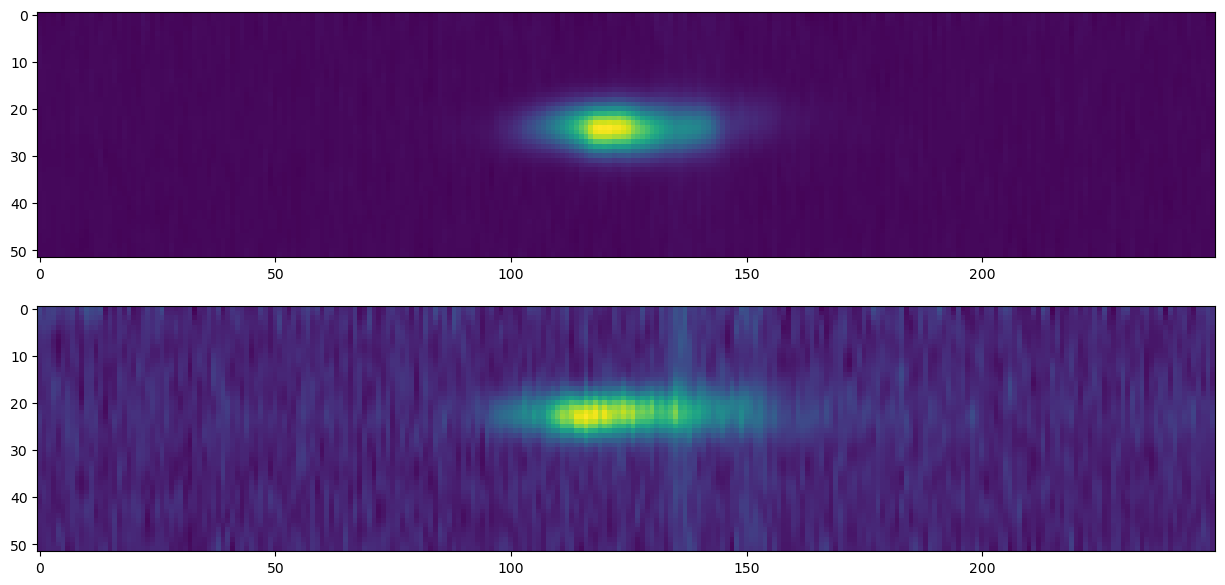

In [41]:
fig, ax = plt.subplots(nrows=2,figsize=(16,7))
ax[0].imshow(cube1[29,:,:])
#ax[0].axvline(line1[1],color='r', label=line1[1])
#ax[0].set_xlim(3480,3630)
#ax[0].legend()
ax[1].imshow(cube2[29,:,:])
#ax[1].set_xlim(3920,4070)
#ax[1].axvline(line2[1],color='r', label=line2[1])
#ax[1].legend()

To overlay both lines we need to create two small cubes of the same size where the lines can be found at (approximately) the same position.

(0.0, 6.617385876951613)

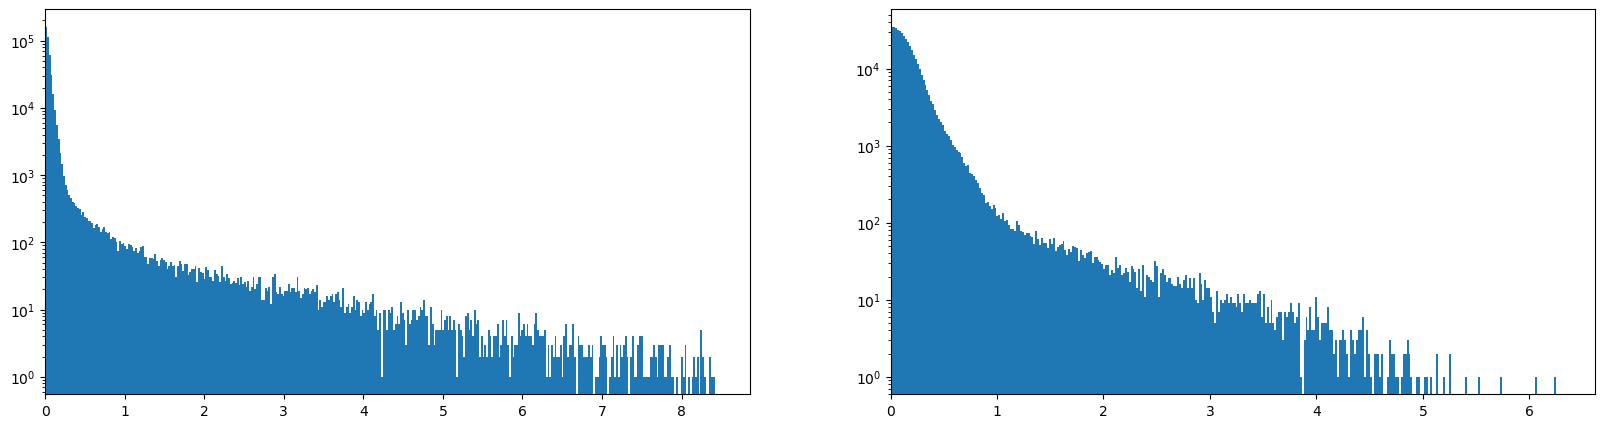

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
ax[0].hist(cube1.flatten(), bins=400)
ax[0].set_yscale('log')
ax[0].set_xlim(0,)
ax[1].hist(cube2.flatten(), bins=400)
ax[1].set_yscale('log')
ax[1].set_xlim(0,)

In [45]:
#MRB
isolevels1 = np.array([0.45, 1.1, 2.3, 4, 6])
isolevels2 = np.array([0.7, 1.3, 2.1, 3, 4])
isolevels = [isolevels1, isolevels2]

In [46]:
coords = np.array([ralim, declim, vlim])
coords

array([[2.15470951e-02, 2.49404672e-02],
       [4.22059556e-01, 4.25096889e-01],
       [6.39009740e+03, 6.41435000e+03]])

In [47]:
color1 = c3.create_colormap('Greens', isolevels1)
color2 = c3.create_colormap('Reds', isolevels2)
colors = [color1,color2]

In [48]:
meta = {'generator':'create_x3d python module',
       'creator':'Name Surname',
       'title':cubehead['OBJECT'],
        'numberofelements':f'{len(isolevels)} layers',
        'description':'data cube of %s'%cubehead['OBJECT']
       }

In [49]:
x3dname = 'OIII_1-NII_1.x3d'

In [50]:
file = c3.write_x3d('./cube_x3d/examples/%s'%x3dname, delta_arcsec,
                    coords, header=cubehead, units=["e17 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'], meta=meta, picking=False)

#also need html.func_pick() if picking=True

[[ -6.10790397   0.           6.10790397]
 [ -5.4672       0.           5.4672    ]
 [-12.1263       0.          12.1263    ]]


In [51]:
file.make_layers(cubes, isolevels, colors)
file.make_outline()
#file.make_galaxies(gals=gals, labels=True)
file.make_image2d(imcol=None, img_shape=None)
file.make_ticklines()
file.make_labels(gals=None, axlab='diff') 
#html.func_scalev(axes) should be same as axlab, not func_axes() though.
file.close()

In [52]:
tabtitle = f'{cubehead["OBJECT"]}'
pagetitle = f'3D interactive datacube: {cubehead["OBJECT"]}'
# add in desc for 2d image: <br>\n\t Background image: {survey}
desc = f"Object: {cubehead['OBJECT']}.<t> Telescope: {cubehead['TELESCOP']}, Instrument: {cubehead['INSTRUME']}, Obsmode: {cubehead['OBSMODE']}.<br>\n\t Center: (RA,DEC)=({np.round(ramean,5)}, {np.round(decmean,5)}). Date-obs: {cubehead['DATE-OBS']}"

In [53]:
colmaps = ['Greens', 'Reds', 'magma', 'CMRmap', 'inferno', 'plasma', 'viridis', 'Greys',
           'Blues', 'OrRd', 'PuRd', 'Reds', 'Spectral', 'Wistia',
          'YlGn', 'YlOrRd', 'afmhot', 'autumn', 'cool', 'coolwarm',
          'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_heat',
          'gist_ncar', 'gist_stern', 'gnuplot', 'gnuplot2', 'hot',
          'nipy_spectral', 'prism', 'winter', 'Paired']

In [25]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [57]:
html = c3.write_html('./cube_x3d/examples/%s.html'%x3dname.split('.')[0], 
                    units=["e17 "+cubehead["BUNIT"], 'arcsec', 'arcsec', 'angstrom'],
                     tabtitle=tabtitle, pagetitle=pagetitle,
                     description=desc)

In [58]:
html.func_layers(isolevels)
#html.func_galaxies(gals)
#html.func_gallab()
html.func_grids()
html.func_axes('diff')
#html.func_pick() #for coordinate picking
html.start_x3d()
html.viewpoints(maxcoord=file.diff_coords[:,2])
html.close_x3d(x3dname)
html.buttons(isolevels, colors, colormaps=colmaps, hide2d=True, scalev=True, move2d=True, lineLabs=[r'OIII ($4958.911 \, \mathring{A}$)', r'NII ($6548.05 \, \mathring{A}$)'])
#func_move2dimage, func_setCenterOfRotation, func_colormaps and func_scalev must always go after buttons
html.func_image2d()
#html.func_setCenterOfRotation(['0 0 -19', '0 0 -4','0 0 17.5']) #['0 0 -29.3', '0 0 19.1'] for MRB
html.func_colormaps(isolevels)
html.func_scalev(gals=None, axes='diff', coords=file.diff_coords, vmax=file.diff_coords[2,2]) #file.diff_coords[2,2]
html.func_move2dimage(real_vmax=file.real_coords[2,2], diff_vmax=file.diff_coords[2,2])
html.close_html()